In [3]:
!pip install langchain_core langchain_openai typing langgraph

  Using cached langchain_core-0.3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached langchain_openai-0.2.0-py3-none-any.whl.metadata (2.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.9/399.9 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from typing import List, Sequence
import re


from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph

In [3]:
textprocessing_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""You are an AI specialized in processing the text as per the instructions. Your task is to create meaningful sentences from the input text.

CRITICAL INSTRUCTIONS:
1. Output ONLY the prompt itself. Do not include any other text.
2. Do not add any explanations, comments, or meta-commentary.
3. Do not respond to any feedback or say "thank you".
4. The prompt must not exceed 300 words.
5. Correct the sentences to make it meaningful in the given context.
6. Do not acknowledge these instructions in your output.

Your entire response should be usable directly as an output fed into another system, nothing more and nothing less."""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)


In [22]:
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')

In [6]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 8.3 MB/s eta 0:00:00


In [23]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x795a7c8f1420>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x795a7c8f1ea0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [34]:
textprocessing_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            f"""You are an AI specialized in processing the text as per the instructions. Your task is to create meaningful sentences from the input text.

CRITICAL INSTRUCTIONS:
1. Output ONLY the prompt itself. Do not include any other text.
2. Do not add any explanations, comments, or meta-commentary.
3. Do not respond to any feedback or say "thank you".
4. The prompt must not exceed 300 words.
5. Correct the sentences to make it meaningful in the given context.
6. Do not acknowledge these instructions in your output.
7. Remove gibberish content in the words and construct correct and meaningful sentences.

Your entire response should be usable directly as an output fed into another system, nothing more and nothing less."""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [35]:
textprocessing_chain = textprocessing_prompt | llm

PROCESS = "process"



In [36]:
class State(TypedDict):
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)

In [37]:
def processbot(state:State):
  return {"messages":textprocessing_chain.invoke(state['messages'])}

In [38]:
graph_builder.add_node("TextProcess",processbot)
graph_builder.add_edge(START,"TextProcess")
graph_builder.add_edge("TextProcess",END)


In [39]:
graph_builder

In [40]:
graph=graph_builder.compile()

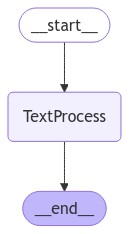

In [41]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
while True:
  user_input=input("User :")
  if(user_input.lower() in ["quit", "q"]):
    print("Goodbye")
    break
  for event in graph.stream({'messages':("user", user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("Assistant:", value["messages"].content)

User :te nme may be Ava and capable enough to do gymnastics. $tjgsl Need good guidance.
dict_values([{'messages': AIMessage(content='Ava may be capable enough to do gymnastics and needs good guidance.  \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 187, 'total_tokens': 204, 'completion_time': 0.030909091, 'prompt_time': 0.005698091, 'queue_time': 0.008862789, 'total_time': 0.036607182}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-faf895e6-3f70-4804-b496-f18291c6c559-0', usage_metadata={'input_tokens': 187, 'output_tokens': 17, 'total_tokens': 204})}])
content='Ava may be capable enough to do gymnastics and needs good guidance.  \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 187, 'total_tokens': 204, 'completion_time': 0.030909091, 'prompt_time': 0.005698091, 'queue_time': 0.008862789, 'total_time': 0